### Imports

In [129]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom libraries
import src.util
from src.util import UtilityFunctions as uf

# reload the custom library, 
# Need to be executed every time new functions are added to util.py 
from importlib import reload
reload(src.util)   



<module 'src.util' from '/Users/thomas/Desktop/DesigningAlgorithmicMedia/src/util.py'>

#### Import dataset

In [ ]:
# Load the CSV file
df = pd.read_csv('data/raw/EVS_WVS_Joint_Csv_v5_0.csv')

### Data explorations

#### data cleaning 

Drop columns that aren't relevant and modify others into numerical value 

In [ ]:
usa_df = df[df['cntry'] == 840]


# drop following columns, doi, cntry_AN, lnge_iso, version, doi_gesis, doi_wvsa, reg_nuts1, reg_nuts2
columns_to_drop = ['doi_gesis','doi_wvsa', 'cntry_AN', 'lnge_iso', 'version', 'reg_nuts1', 'reg_nuts2', 'X002_02B','V002A_01','V001A_01']
uf.drop_columns(usa_df, columns_to_drop)

# set study title to 1 if it starts with EVS5, else 0 for WVS7
usa_df.loc[:, 'studytit'] = usa_df['studytit'].apply(lambda x: 1 if str(x).startswith('EVS5') else 0)
usa_df['studytit'] = usa_df['studytit'].astype(int)

# set versn_s to 2022 if it starts with 5, else 2024, deduced from the data
usa_df.loc[:, 'versn_s'] = usa_df['versn_s'].apply(lambda x: 2022 if str(x).startswith('5') else 2024)
usa_df['versn_s'] = usa_df['versn_s'].astype(int)

uf.print_non_numeric_columns(usa_df)



In [ ]:
# Count rows with any negative value while handling strings
count_negative_rows = (usa_df.apply(pd.to_numeric, errors='coerce') < 0).any(axis=1).sum()
print(f"Rows with negative values: {count_negative_rows}")

# We gather that every row has at least one negative value, so we will replace them with 0 
# since anything negative is either don't know or refused to answer, NA or missing.
# Replace negative values with 0
usa_df = usa_df.map(lambda x: 0 if x < 0 else x)

#drop columns with fewer than `threshold` unique values
columns_to_drop = list(uf.few_unique_values_columns(usa_df,1).keys())
uf.drop_columns(usa_df, columns_to_drop)


In [137]:
# Select only numeric columns
df_numeric = usa_df.select_dtypes(include=[float, int])

# features = df_numeric.drop(columns=['E033'])  # Drop the column used for coloring

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)


In [138]:
# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# pca_df['E033'] = df['E033']  # Add the coloring feature

# Show explained variance ratio
print(pca.explained_variance_ratio_)



[0.08083347 0.05948251]


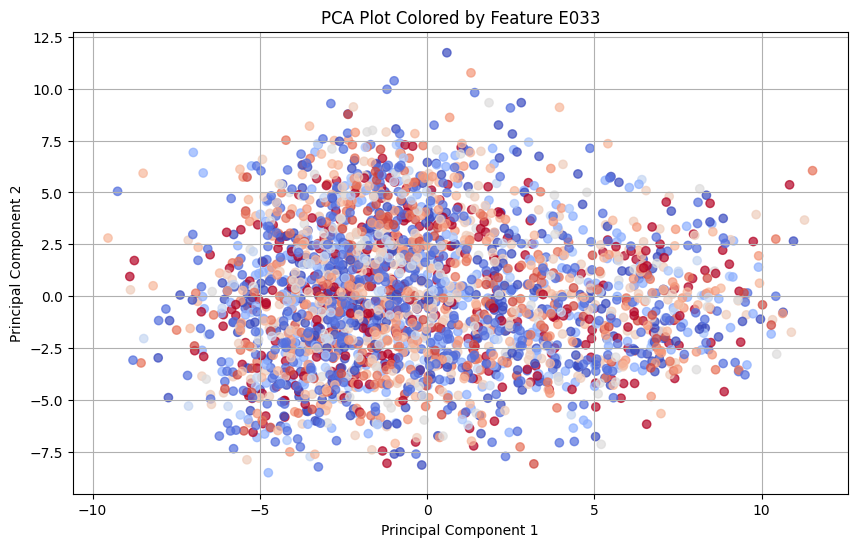

In [50]:
# Normalize the E033 values for color mapping
norm = plt.Normalize(pca_df['E033'].min(), pca_df['E033'].max())
cmap = plt.get_cmap('coolwarm')  # Get the colormap from blue to red

# Map E033 values to colors
colors = cmap(norm(pca_df['E033']))

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x=pca_df['PC1'], y=pca_df['PC2'], c=colors, alpha=0.7)

# Create colorbar
# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
# cbar.set_label('E033 Value')

# Customize plot
plt.title('PCA Plot Colored by Feature E033')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

<Axes: >

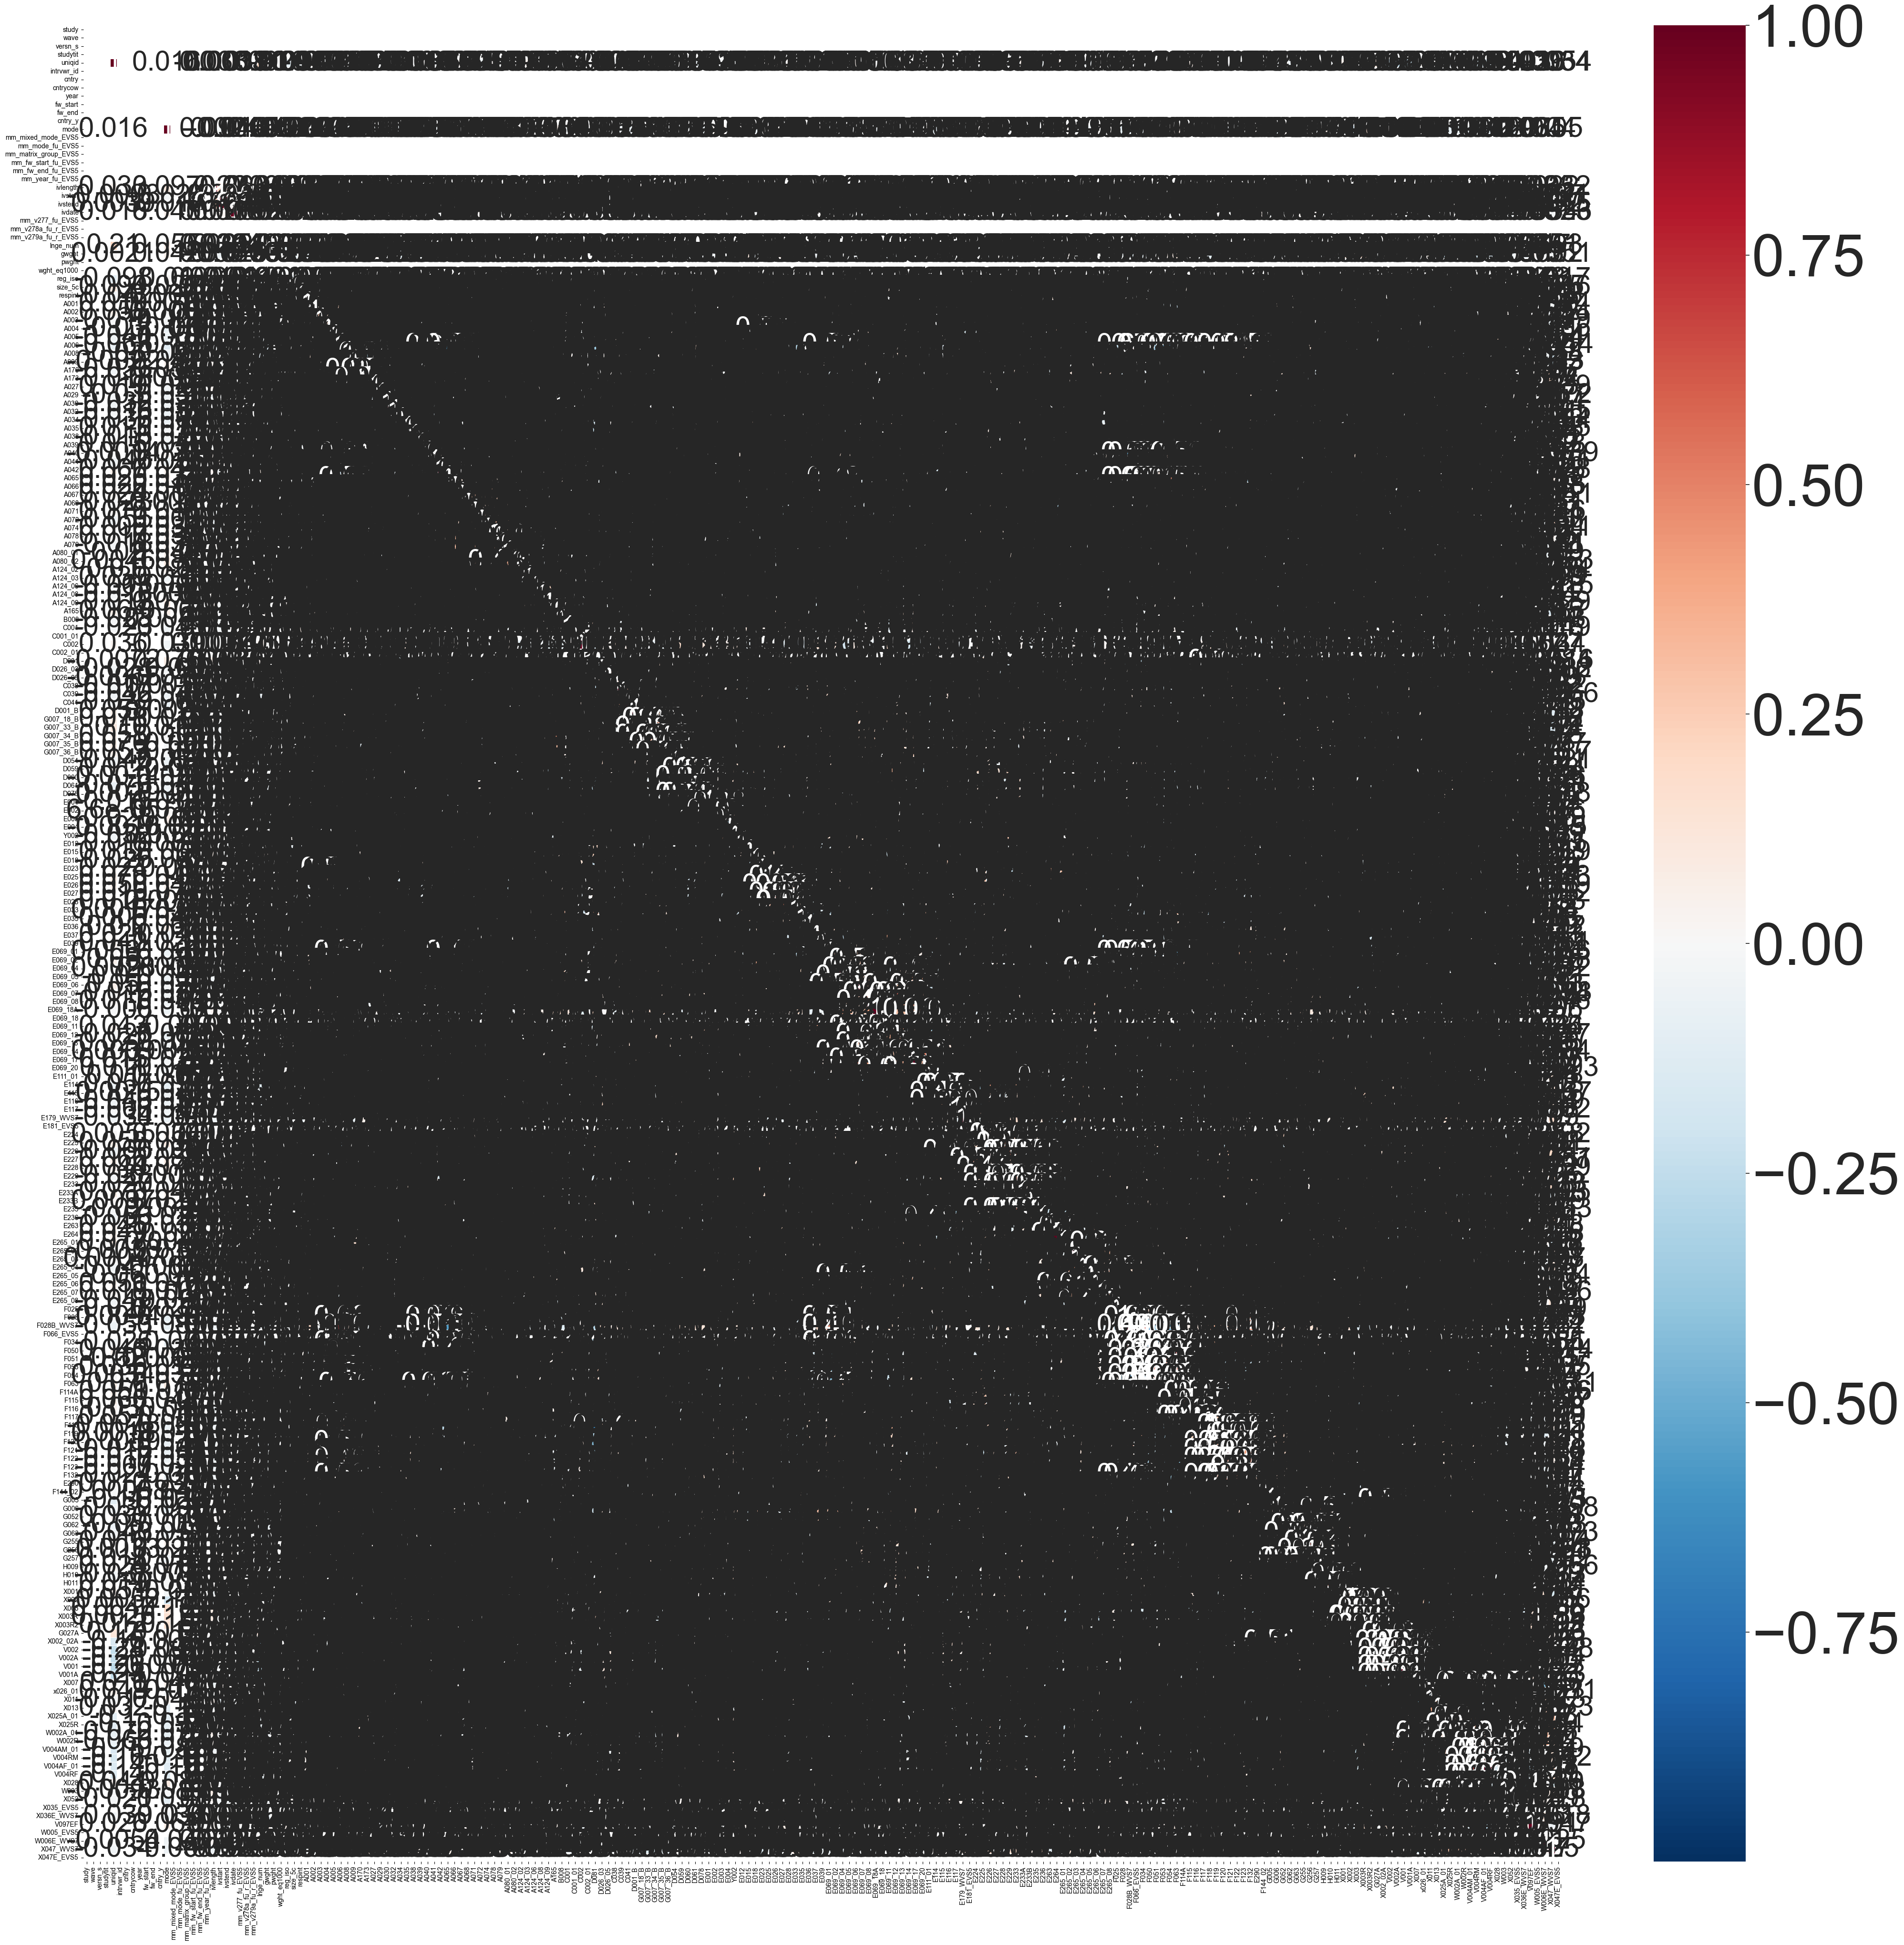

In [109]:
corr = usa_df.corr(method='pearson', numeric_only=True)
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True, linewidth=0.5, ax=ax, annot_kws={"size":42},)

/Users/thomas/DesigningAlgorithmicMedia/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/thomas/DesigningAlgorithmicMedia/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

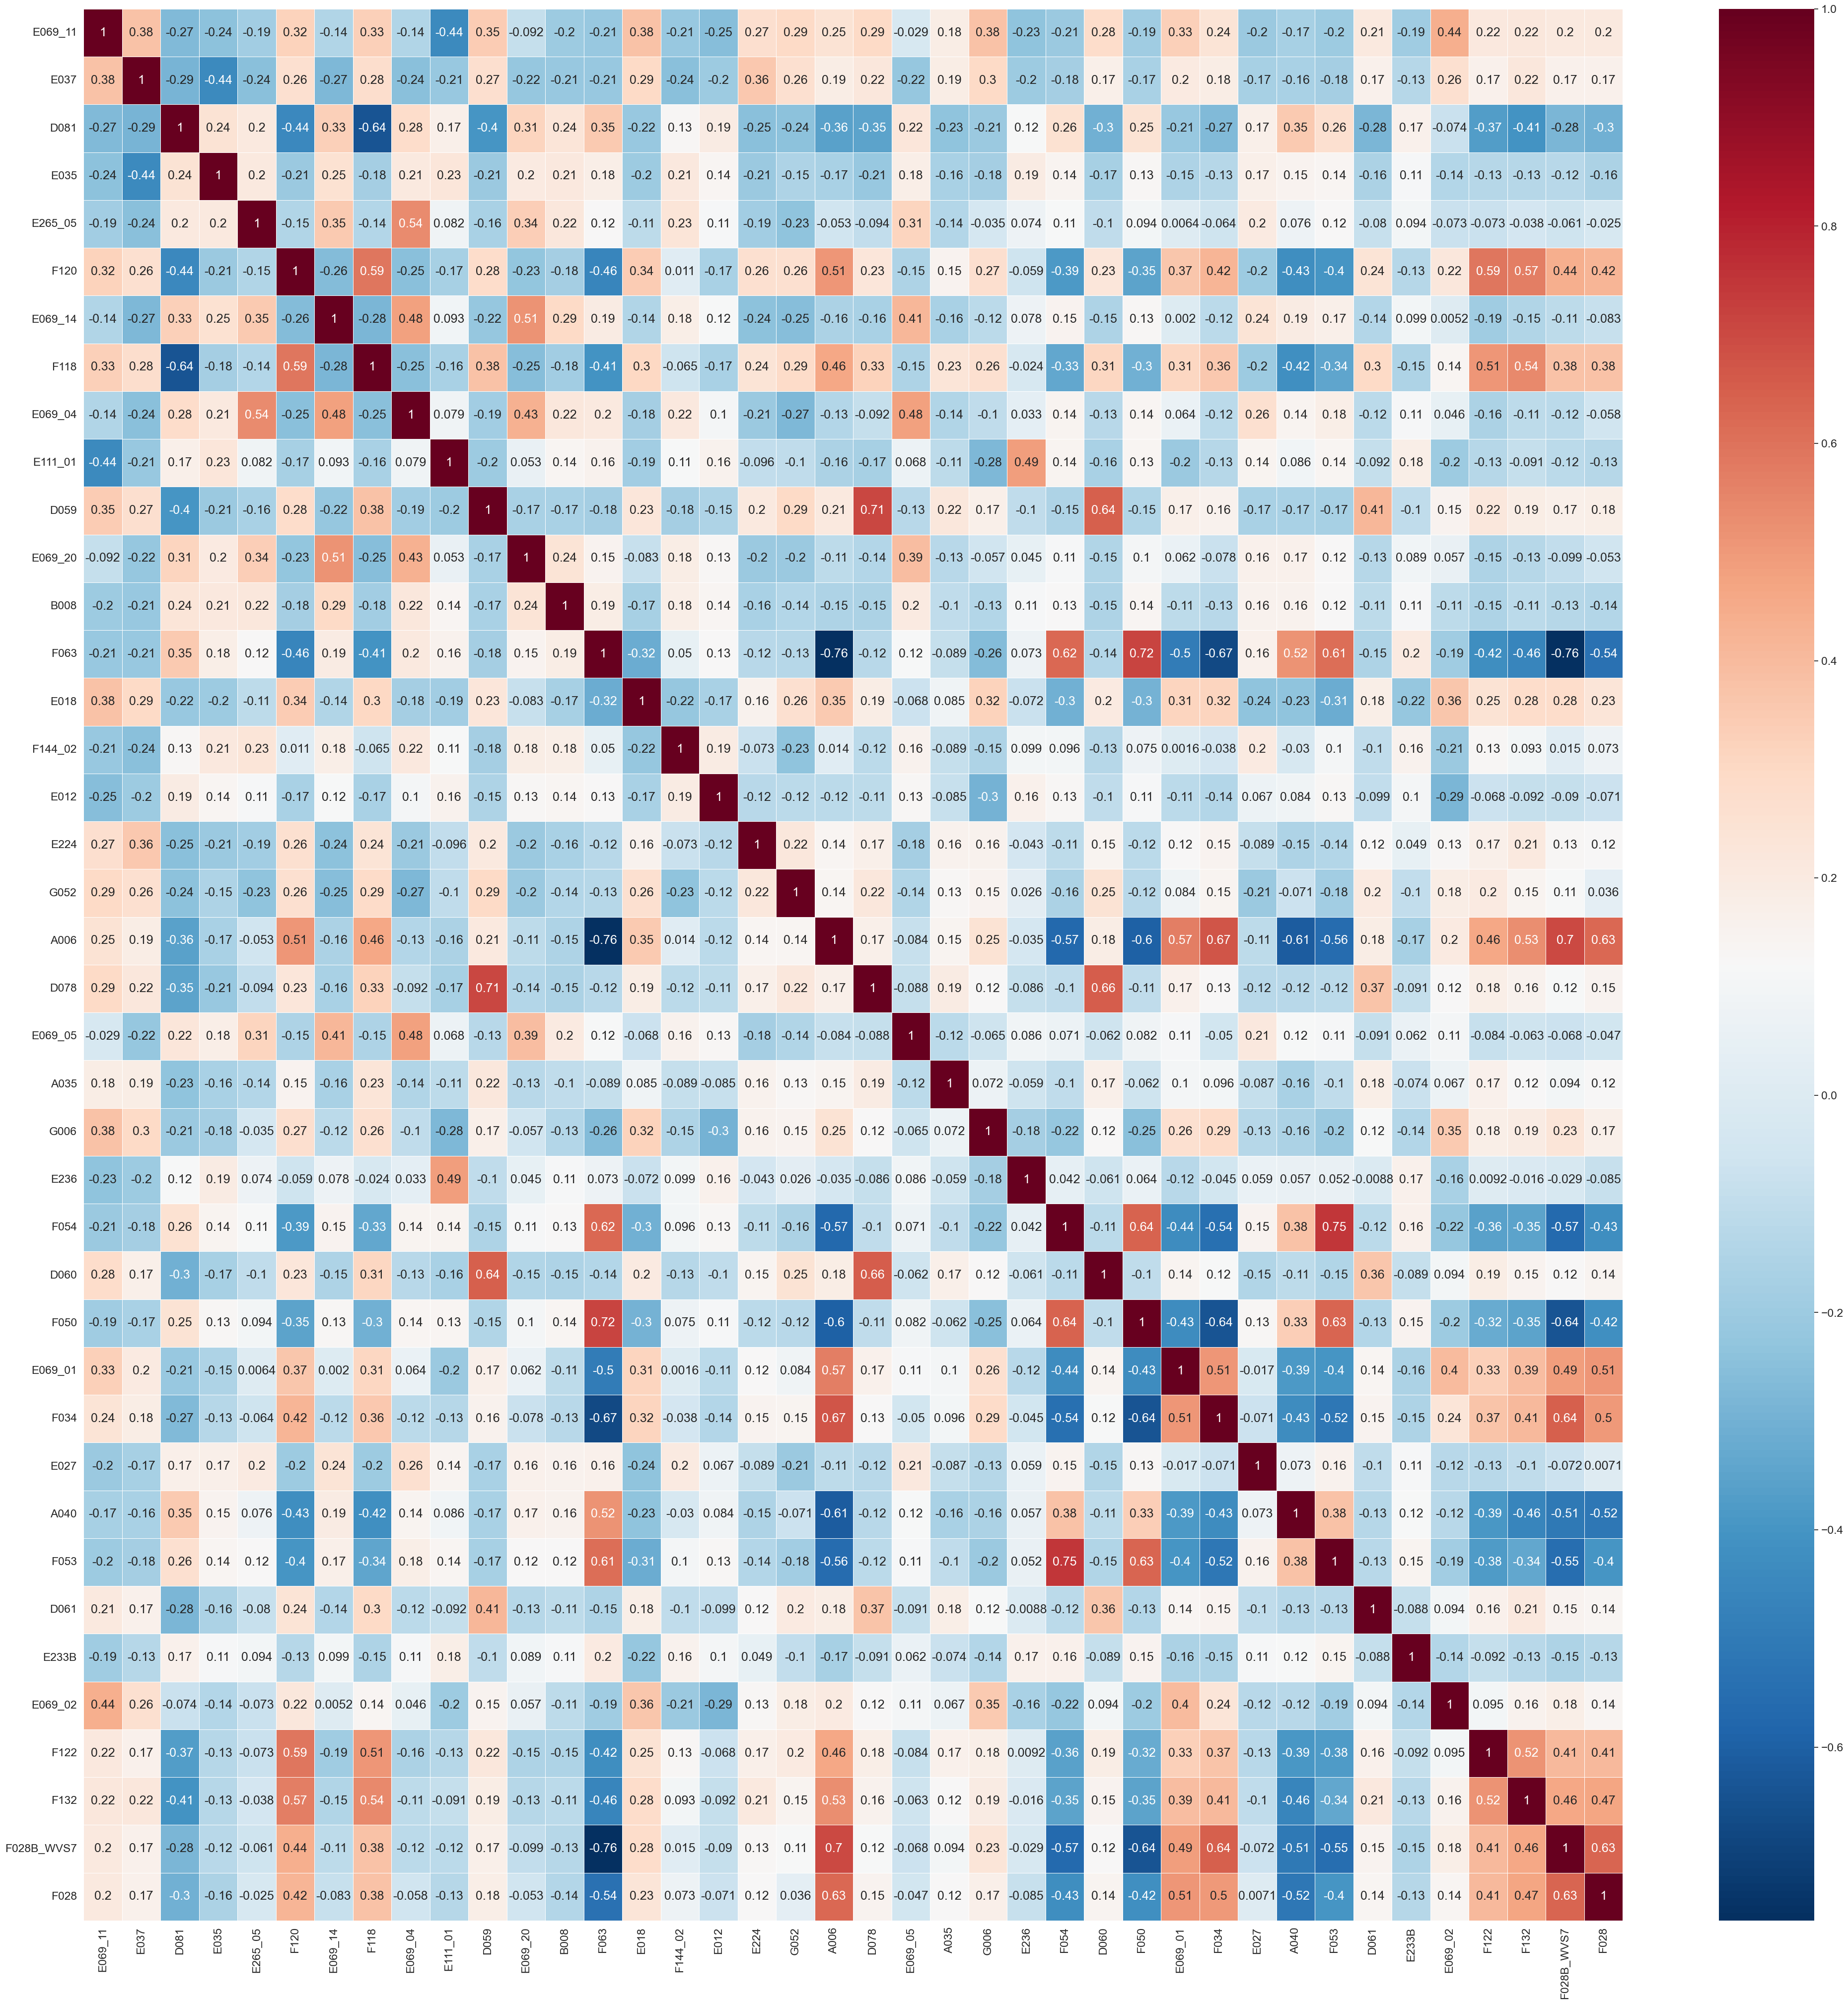

In [135]:
# sns.set(font_scale=.5)
# usa_df.corrwith(usa_df['E033']).abs().sort_values().plot(kind='barh',figsize=(10,10))

# Create a list of the top 40 features that are most correlated with E033
NUMBER_OF_FEATURES = 40
corr = usa_df.drop('E033', axis=1).corrwith(usa_df['E033']).abs().sort_values(ascending=False)
n_features = corr.head(NUMBER_OF_FEATURES)
# print(n_features)

filter_df = uf.filter_features(usa_df, n_features.index)
corr = filter_df.corr(method='pearson', numeric_only=True)

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True, linewidth=0.5, ax=ax, annot_kws={"size":18},)


1. PCA
    PCA 2, see if clusters appear 
    Color the pca scatterplot in colors tied to left or right leaning.

2. Inspect covariance matrix
    feature selection